# Download and Install CLIP Dependencies

In [1]:
# installing some dependencies, CLIP was released in PyTorch (thanks to Roboflow's tutorial for the setup template!)
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

# install clip
!pip install git+https://github.com/openai/CLIP.git

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.2MB/s eta 0:04:26tcmalloc: large alloc 1147494400 bytes == 0x562e228da000 @  0x7f93f2d5a615 0x562de922106c 0x562de9300eba 0x562de9223e8d 0x562de931599d 0x562de9297fe9 0x562de9292b0e 0x562de922577a 0x562de9297e50 0x562de9292b0e 0x562de922577a 0x562de929486a 0x562de93167c6 0x562de9293ee2 0x562de93167c6 0x562de9293ee2 0x562de93167c6 0x562de9293ee2 0x562de93167c6 0x562de9398431 0x562de92f9049 0x562de9263c84 0x562de92248e9 0x562de9298ade 0x562de922569a 0x562de9293a45 0x562de9292e0d 0x562de922577a 0x562de9293a45 0x562de922569a 0x562de9293a45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:26tcmalloc: large alloc 1434370048 bytes == 0x562e66f30000 @  0x7f93f2d5a615 0x562de922106c 0x562de9300eba 0x562de9223e8d 0x562de931599d 0x562de9297fe9 0x562de9292b0e 0x562de922577a 0x562de9297e50 0x562de9292b0e 0x562de922577a 0x562de929486a 0x562de93167

# Begin Our Style Transfer

## Import Necessities and Setup Models

In [2]:
import clip
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import vgg19
from torch.optim import Adam
from PIL import Image
from tqdm.notebook import tqdm
from moviepy.editor import ImageSequenceClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3579904/45929032 bytes (7.8%)7569408/45929032 bytes (16.5%)11649024/45929032 bytes (25.4%)15646720/45929032 bytes (34.1%)19521536/45929032 bytes (42.5%)23519232/45929032 bytes (51.2%)27516928/45929032 bytes (59.9%)31481856/45929032 bytes (68.5%)35586048/45929032 bytes (77.5%)39682048/45929032 bytes (86.4%)44023808/45929032 bytes (95.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg = vgg19(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [4]:
class Hook:
  def __init__(self):
    self.input = None
    self.output = None
  
  def hook_fn(self, module, input, output):
    self.input = input
    self.output = output

vgg_hook = Hook()

vgg.features[19].register_forward_hook(vgg_hook.hook_fn)

In [5]:
model, clip_transforms = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 67.2MiB/s]


In [6]:
universal_transforms = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor()
])
vgg_transforms = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_transforms = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

## Define our Image and begin Tuning

In [7]:
# No image in mind? Here's some to get started!
!wget -O portrait.jpg https://images.unsplash.com/photo-1519895609939-d2a6491c1196?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=634&q=80
!wget -O house.jpg https://images.unsplash.com/photo-1523217582562-09d0def993a6?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=80 

--2021-03-08 14:32:21--  https://images.unsplash.com/photo-1519895609939-d2a6491c1196?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D
Resolving images.unsplash.com (images.unsplash.com)... 199.232.66.208, 2a04:4e42:50::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.66.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3467392 (3.3M) [image/jpeg]
Saving to: ‘portrait.jpg’

portrait.jpg        100%[===================>]   3.31M  --.-KB/s    in 0.04s   

2021-03-08 14:32:21 (77.9 MB/s) - ‘portrait.jpg’ saved [3467392/3467392]

--2021-03-08 14:32:21--  https://images.unsplash.com/photo-1523217582562-09d0def993a6?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D
Resolving images.unsplash.com (images.unsplash.com)... 199.232.66.208, 2a04:4e42:50::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.66.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2961781 (2.8M) [image/jpeg]
Saving to: ‘house.

0 0.7986097931861877
100 0.32166463136672974
200 0.2804166376590729
300 0.24821969866752625
400 0.20961950719356537
500 0.18228378891944885
600 0.16855153441429138
700 0.17893734574317932
800 0.1378510296344757
900 0.16819798946380615
999 0.1257687360048294



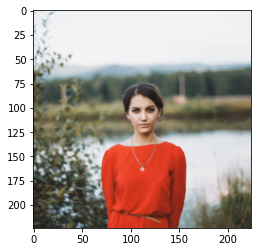

In [14]:
image_path = "portrait.jpg" #@param {type:"string"}
clip_input = "a leonardo da vinci mona lisa style painting" #@param {type:"string"}
optim_iterations = 1000 #@param {type:"integer"}
log_content_lambda = -2 #@param {type:"slider", min:-4, max:4, step:0.5}
log_tv_lambda = 3 #@param {type:"slider", min:-4, max:4, step:0.5}
log_lr = -1 #@param{type:"slider", min:-4, max:4, step:0.5}
vgg_content_loss = True #@param{type:"boolean"}
lambda_val = 10**log_content_lambda
lambda_tv = 10**log_tv_lambda
lr = 10**log_lr

criterion = [clip_input]

text = clip.tokenize(criterion).to(device)

def show_pt_image(img, epoch=None):
  img = img.squeeze().cpu().detach().permute(1,2,0).numpy().clip(0,1)
  if isinstance(epoch, int):
    plt.imsave('sample{}.jpg'.format(epoch), img)
  else:
    plt.imshow(img)

starting_img = universal_transforms(Image.open(image_path)).to(device)
modified_img = starting_img.detach().clone().requires_grad_()
show_pt_image(starting_img)

# define content goal
with torch.no_grad():
  vgg(vgg_transforms(starting_img).unsqueeze(0))
goal_conv4_1 = vgg_hook.output

optim = Adam([modified_img], lr=lr)

# optimize
pbar = tqdm(range(optim_iterations))
for i in pbar:
  # content loss
  if vgg_content_loss:
    vgg(vgg_transforms(modified_img).unsqueeze(0))
    loss = torch.square(goal_conv4_1 - vgg_hook.output).mean() * lambda_val
  else:
    loss = torch.square(modified_img-starting_img).mean() * lambda_val
  # TV loss
  a = torch.square(
      modified_img[:, :223, :223] - modified_img[:, 1:, :223]
  )
  b = torch.square(
      modified_img[:, :223, :223] - modified_img[:, :223, 1:]
  )
  loss += torch.pow(a+b, 1.25).mean() * lambda_tv
  # clip loss
  loss += 1 - model(clip_transforms(modified_img).unsqueeze(0), text)[0].sum()/100
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description("loss: {:.4f}".format(loss.item()))
  if i % 100 == 0 or i == optim_iterations-1:
    print(i, loss.item())
    show_pt_image(modified_img, epoch=i)

In [15]:
# make a gif from your results (we don't use step 0 and opt for the source image)
ims =  ['sample{}00.jpg'.format(i) for i in range(1,10)] + ['sample999.jpg']
im_arr = [universal_transforms(Image.open(image_path)).permute(1,2,0).numpy()*255] + [plt.imread(im) for im in ims]
ImageSequenceClip(im_arr, fps=8).write_gif('portrait.gif')


[MoviePy] Building file portrait.gif with imageio


 92%|█████████▏| 11/12 [00:01<00:00,  9.93it/s]
